<a href="https://colab.research.google.com/github/luck058/playingWithML/blob/main/PlayingWithML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## https://www.youtube.com/watch?v=c36lUUr864M
Pt. 13

In [ ]:
if False:
  import torch
  import torch.nn as nn
  import torchvision
  import torchvision.transforms as transforms
  import matplotlib.pyplot as plt

  # Device configuration
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Hyper-parameters
  input_size = 784 # 28x28
  hidden_size = 500
  num_classes = 10
  num_epochs = 2
  batch_size = 100
  learning_rate = 0.001

  # MNIST dataset
  train_dataset = torchvision.datasets.MNIST(root='./data',
                                            train=True,
                                            transform=transforms.ToTensor(),
                                            download=True)

  test_dataset = torchvision.datasets.MNIST(root='./data',
                                            train=False,
                                            transform=transforms.ToTensor())

  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

  examples = iter(test_loader)
  example_data, example_targets = next(examples)

  for i in range(6):
      plt.subplot(2,3,i+1)
      plt.imshow(example_data[i][0], cmap='gray')
  plt.show()

  # Fully connected neural network with one hidden layer
  class NeuralNet(nn.Module):
      def __init__(self, input_size, hidden_size, num_classes):
          super(NeuralNet, self).__init__()
          self.input_size = input_size
          self.l1 = nn.Linear(input_size, hidden_size)
          self.relu = nn.ReLU()
          self.l2 = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
          out = self.l1(x)
          out = self.relu(out)
          out = self.l2(out)
          # no activation and no softmax at the end
          return out

  model = NeuralNet(input_size, hidden_size, num_classes).to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Train the model
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          # origin shape: [100, 1, 28, 28]
          # resized: [100, 784]
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          print("#################")
          print("outputs:", outputs.shape)
          print("###############")
          print("inputs:", images.shape)
          break
          loss = criterion(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

  # Test the model
  # In test phase, we don't need to compute gradients (for memory efficiency)
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      for images, labels in test_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model(images)
          # max returns (value ,index)
          _, predicted = torch.max(outputs.data, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network on the 10000 test images: {acc} %')


## Imports/config

### Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import math

### Device configuration

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparameters

In [ ]:
input_size = 5
output_size = 1
hidden_size = 500
num_epochs = 10
batch_size = 4
learning_rate = 0.001


## Data

### Import data

In [ ]:
class LinearDataset(Dataset):
  def __init__(self, train):
    self.x = []
    self.y = []
    self.x_test = []
    self.y_test = []
    self.train = train

    # Includes test and training data
    num_samples = 50

    full_graph = torch.tensor([2*(i) for i in range(num_samples + input_size + output_size)], dtype=torch.float32)

    for i in range(len(full_graph) - input_size - output_size):
      if i%10 != 0:
        self.x.append(full_graph[i : i+input_size])
        self.y.append(full_graph[i+input_size : i+input_size+output_size])
      else:
        self.x_test.append(full_graph[i : i+input_size])
        self.y_test.append(full_graph[i+input_size : i+input_size+output_size])

  def __getitem__(self, index):
    if self.train:
      return self.x[index], self.y[index]
    else:
      return self.x_test[index], self.y_test[index]

  def __len__(self):
    if self.train:
      return len(self.x)
    else:
      return len(self.x_test)


training_dataset = LinearDataset(train=True)
testing_dataset = LinearDataset(train=False)

train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testing_dataset, batch_size=batch_size, shuffle=False)

total_samples = len(training_dataset)

print("Length of training data:", len(training_dataset))
print("Length of test data:", len(testing_dataset))

Length of training data: 45
Length of test data: 5


### Visualise data

tensor([56., 58., 60., 62., 64.])
tensor([66.])
tensor([54., 56., 58., 60., 62.])
tensor([64.])
tensor([ 8., 10., 12., 14., 16.])
tensor([18.])
tensor([50., 52., 54., 56., 58.])
tensor([60.])


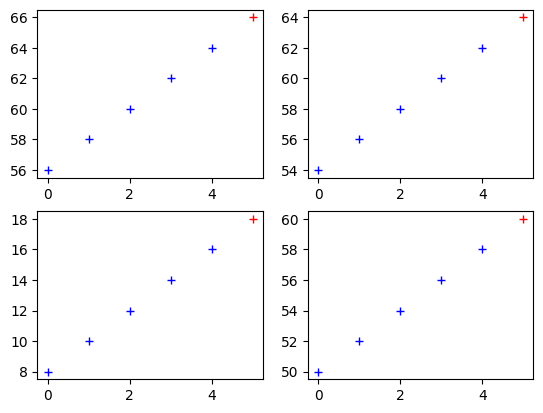

In [ ]:
dataiter = iter(train_loader)
(inputs, labels) = next(dataiter)
for i in range(batch_size):
  plt.subplot(2,math.ceil(batch_size/2),i+1)
  print(inputs[i])
  print(labels[i])
  plt.plot(inputs[i], 'b+')
  plt.plot(input_size, labels[i], 'r+')

plt.show()

## Other function definitions

In [ ]:
def get_test_loss(model, test_loader):
    """Returns the loss of the model on the test data (out of distribution data)"""
    with torch.no_grad():
      for i, (test_inputs, test_labels) in enumerate(test_loader):
          test_outputs = model(test_inputs)
          test_loss = criterion(test_outputs, test_labels)
      return test_loss

def plot_every_epoch_data(axis, data, first_epoch_shown, last_epoch_shown, epoch_length):
  """Plots any data which has one datapoint every epoch on 'axis' (assuming the x axis of 'axis' is steps)"""
  axis.plot(list(range(first_epoch_shown*epoch_length, (last_epoch_shown+1)*epoch_length, epoch_length)), test_history[first_epoch_shown:last_epoch_shown+1])

## Model

### Model definition

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, output_size)

        self.l = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        #out = self.l(x)
        # no activation and no softmax at the end
        return out

### Model, loss and optimiser

In [ ]:
model = NeuralNet(input_size, hidden_size, output_size).to(device)
loss_history = []
test_history = []

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training loop

In [ ]:
# Train the model
n_total_steps = len(train_loader)
test_history.append(get_test_loss(model, test_loader))

for epoch in range(num_epochs):
    loss_history.append([])
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history[-1].append(loss)

        if (i+1) % (n_total_steps//1) == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Find loss on test data
    test_history.append(get_test_loss(model, test_loader))

Epoch [1/10], Step [12/12], Loss: 0.0005
Epoch [2/10], Step [12/12], Loss: 0.0014
Epoch [3/10], Step [12/12], Loss: 0.0003
Epoch [4/10], Step [12/12], Loss: 0.0030
Epoch [5/10], Step [12/12], Loss: 0.0027
Epoch [6/10], Step [12/12], Loss: 0.0005
Epoch [7/10], Step [12/12], Loss: 0.0008
Epoch [8/10], Step [12/12], Loss: 0.0597
Epoch [9/10], Step [12/12], Loss: 0.0135
Epoch [10/10], Step [12/12], Loss: 0.0002


## Testing

### Loss graph

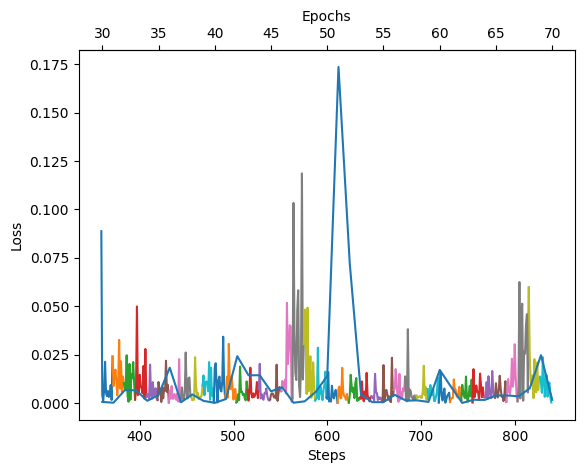

In [ ]:
# Test the model
first_epoch_shown = 30
last_epoch_shown = -1

last_epoch_shown = min(last_epoch_shown, len(loss_history))
if last_epoch_shown == -1:
  last_epoch_shown = len(loss_history)
assert first_epoch_shown <= last_epoch_shown, "First epoch shown is more than last epoch shown"


fig, ax = plt.subplots()

last_plotted_point = [loss_history[0][0]]

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  # Plot the data from the given epoch. Also plots the last datapoint from the previous epoch so the lines join nicely
  epoch_length = len(loss_history[0])
  for epoch, loss_hist_epoch in enumerate(loss_history):
    if epoch_length != len(loss_hist_epoch):
      print("Epoch length changes")

    if epoch >= first_epoch_shown and epoch <= min(last_epoch_shown, len(loss_history)):
      start_epoch_step = epoch * epoch_length
      start_next_epoch_step = (epoch+1) * epoch_length
      # Plot loss graph of training data
      ax.plot(list(range(start_epoch_step-1, start_next_epoch_step)), last_plotted_point + loss_hist_epoch)

    last_plotted_point = [loss_hist_epoch[-1]]

  # Plot out of distribution test at the end of every epoch
  plot_every_epoch_data(ax, test_history, first_epoch_shown, last_epoch_shown, epoch_length)

  ax.set_xlabel("Steps")
  ax.set_ylabel("Loss")
  secax = ax.secondary_xaxis('top', functions=(lambda x: x/len(loss_hist_epoch), lambda x: x*len(loss_hist_epoch)))
  secax.set_xlabel("Epochs")
  plt.show()

### Final model prediction on test data

In [ ]:
with torch.no_grad():
    outputs = model(inputs)

## Test functions

In [ ]:
a = [1,2,3]
print(a[1:5])

[2, 3]
